In [2]:
import GPy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

from tqdm import tqdm
import haversine as hs
import networkx as nx

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'

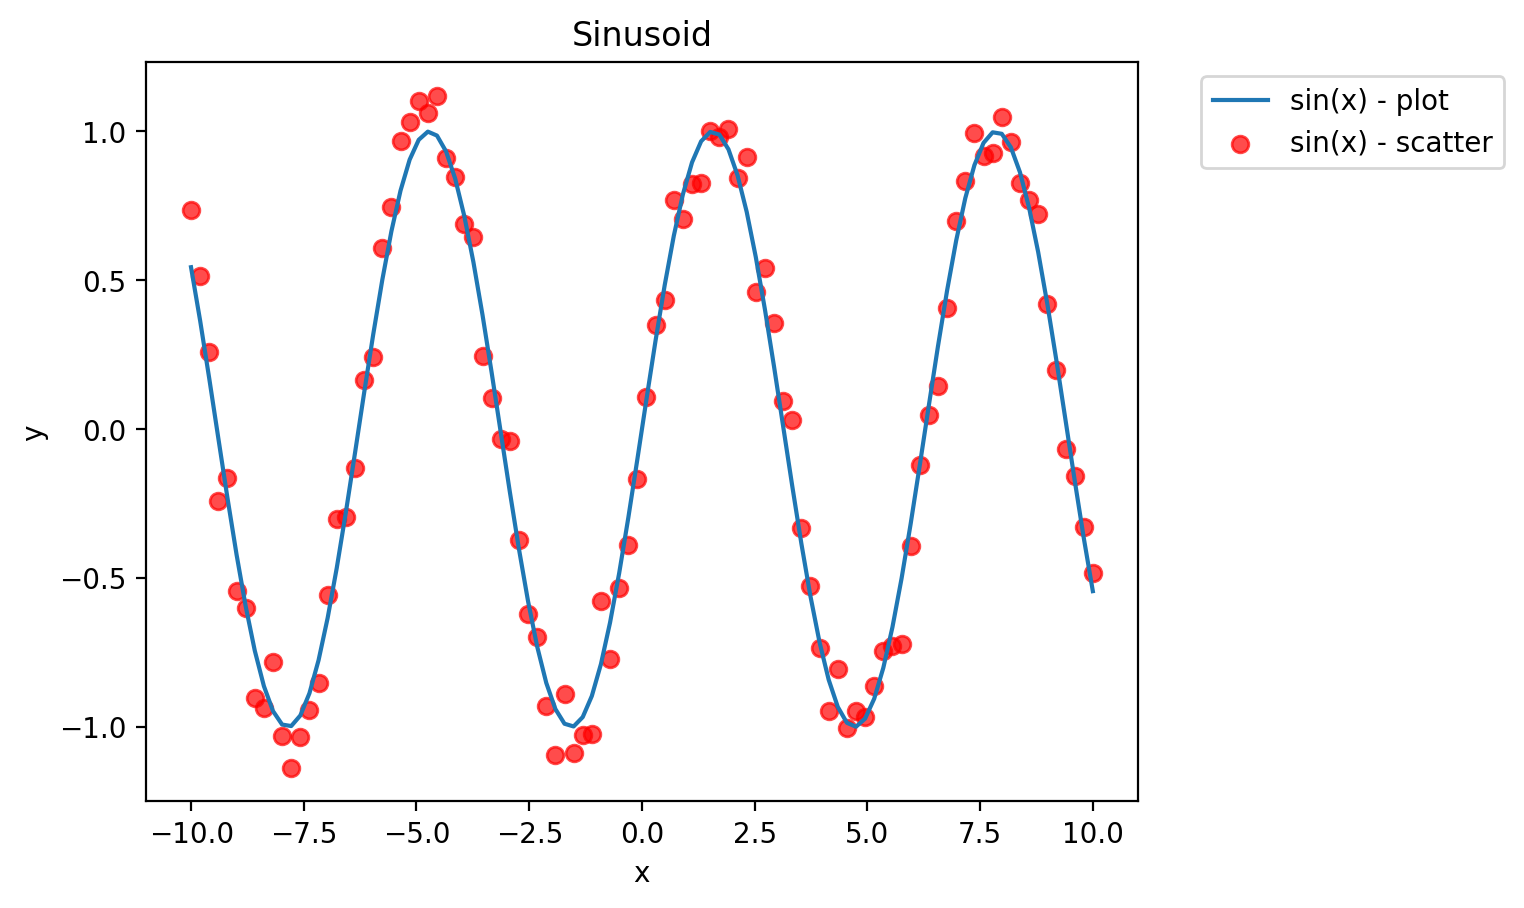

In [3]:
n_points = 100

x = torch.linspace(-10, 10, n_points)

y = torch.sin(x) + torch.randn(n_points) * 0.1
plt.plot(x, torch.sin(x) );
plt.scatter(x, y, c = 'red', alpha = 0.7)
plt.title('Sinusoid')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['sin(x) - plot', 'sin(x) - scatter'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

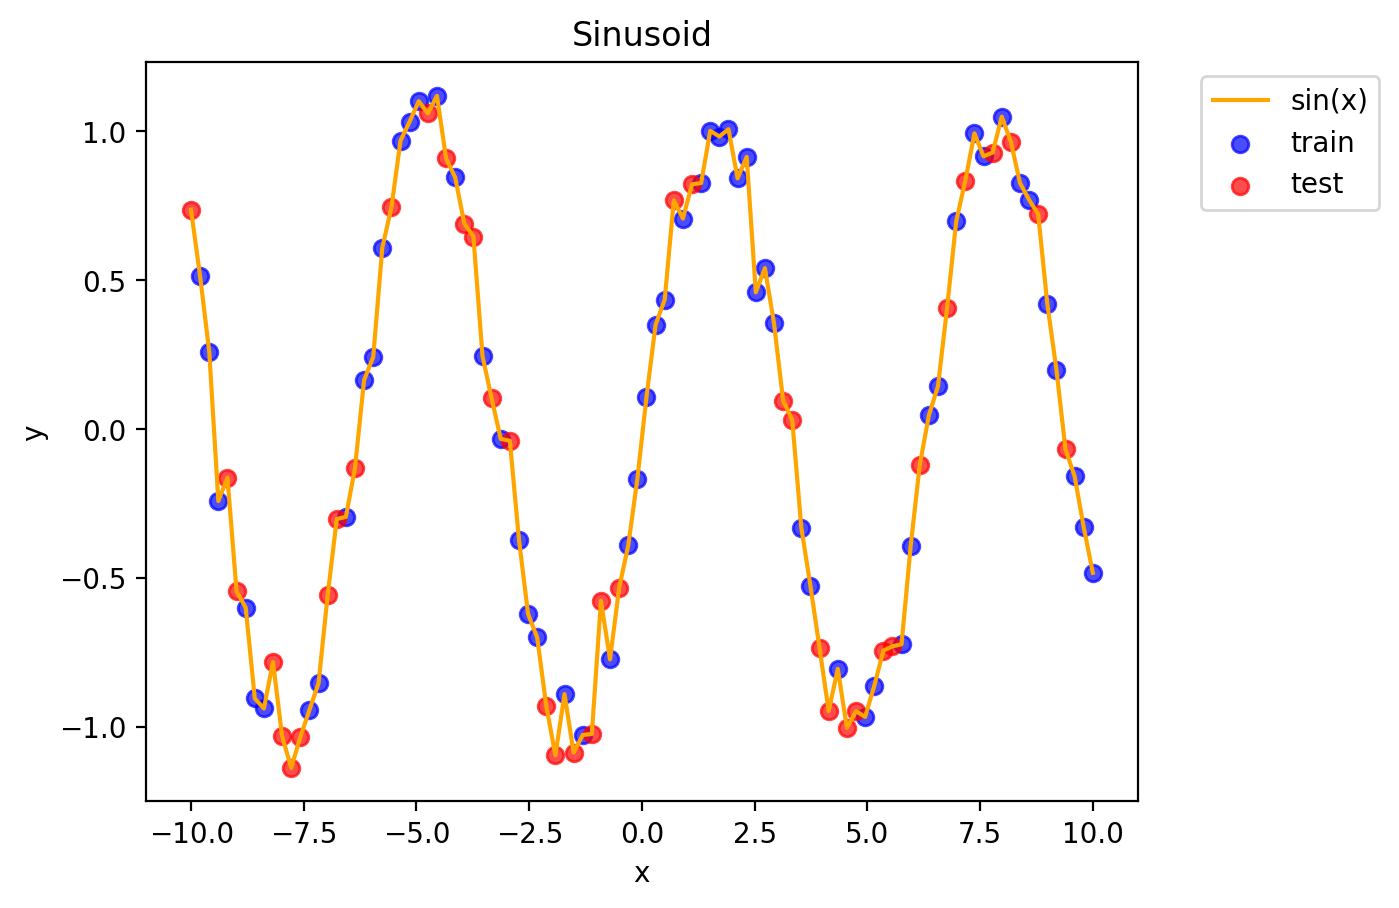

In [4]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4)
plt.plot(x, y, color = 'orange')
plt.scatter(train_x, train_y, c = 'blue', alpha = 0.7)
plt.scatter(test_x, test_y, c='red', alpha = 0.7)
plt.title('Sinusoid')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['sin(x)', 'train', 'test'],bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [5]:
def sort_points(train_pt, train_pred):
    train_pt = train_pt.numpy()
    output = dict()
    for i in range(len(train_pt)):
        output[train_pt[i]] = train_pred[i][0]
    
    keys = list(output.keys())
    keys.sort()
    sorted_output = {i: output[i] for i in keys}
    return sorted_output.keys(), sorted_output.values()

In [6]:
def get_gaussian(x):
    d = ((x - x.T)**2)**0.5
    d = torch.where(d==0, torch.min(d[d!=0])/2, d)  # self distance is 0, so replace it with half of the min distance
    A = torch.exp(- 0.5 * (d / torch.std(d)) ** 2)
    
    return A

In [7]:
def adjacency_matrix_to_edge_list(A):
    edge_list = []
    edge_weights = []
    num_nodes = A.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_weights.append(A[i, j])
            if A[i, j] != 0:
                edge_list.append((i, j))
    
    return torch.tensor(edge_list).T.to(device), torch.tensor(edge_weights).to(device)

In [8]:
train_edge_list, train_edge_weights = adjacency_matrix_to_edge_list(get_gaussian(train_x.unsqueeze(1)))
test_edge_list, test_edge_weights = adjacency_matrix_to_edge_list(get_gaussian(test_x.unsqueeze(1)))

train_data = Data(x=train_x, edge_index=train_edge_list,edge_weights = train_edge_weights, y=train_y)
test_data = Data(x=test_x, edge_index=test_edge_list,edge_weights = test_edge_weights, y=test_y)

In [9]:
class RegressionModel_1(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel_1, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weights):
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

class RegressionModel_2(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel_2, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear1 = nn.Linear(16, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weights):
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weights)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
    
class RegressionModel_3(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel_3, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 16)
        self.linear1 = nn.Linear(16, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weights):
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weights)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

# With One Layer

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:16<00:00, 308.90it/s]


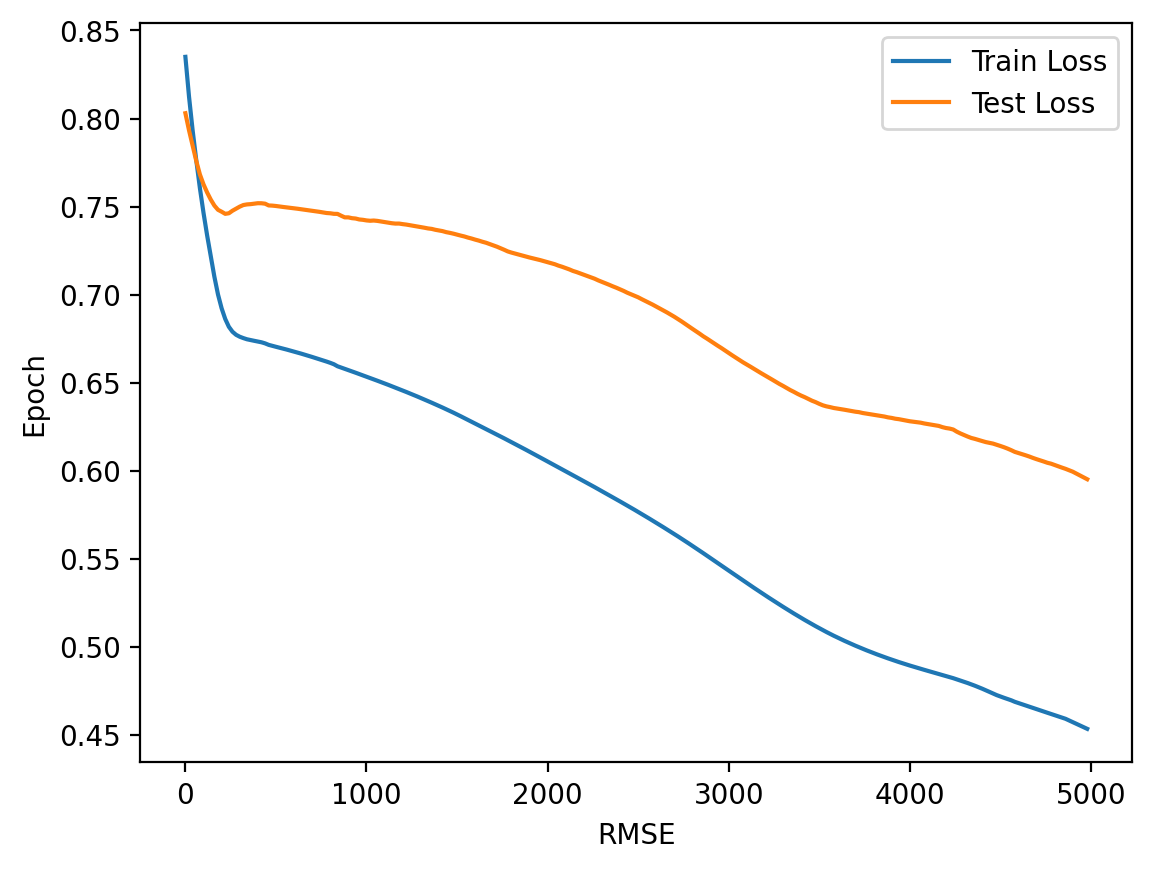

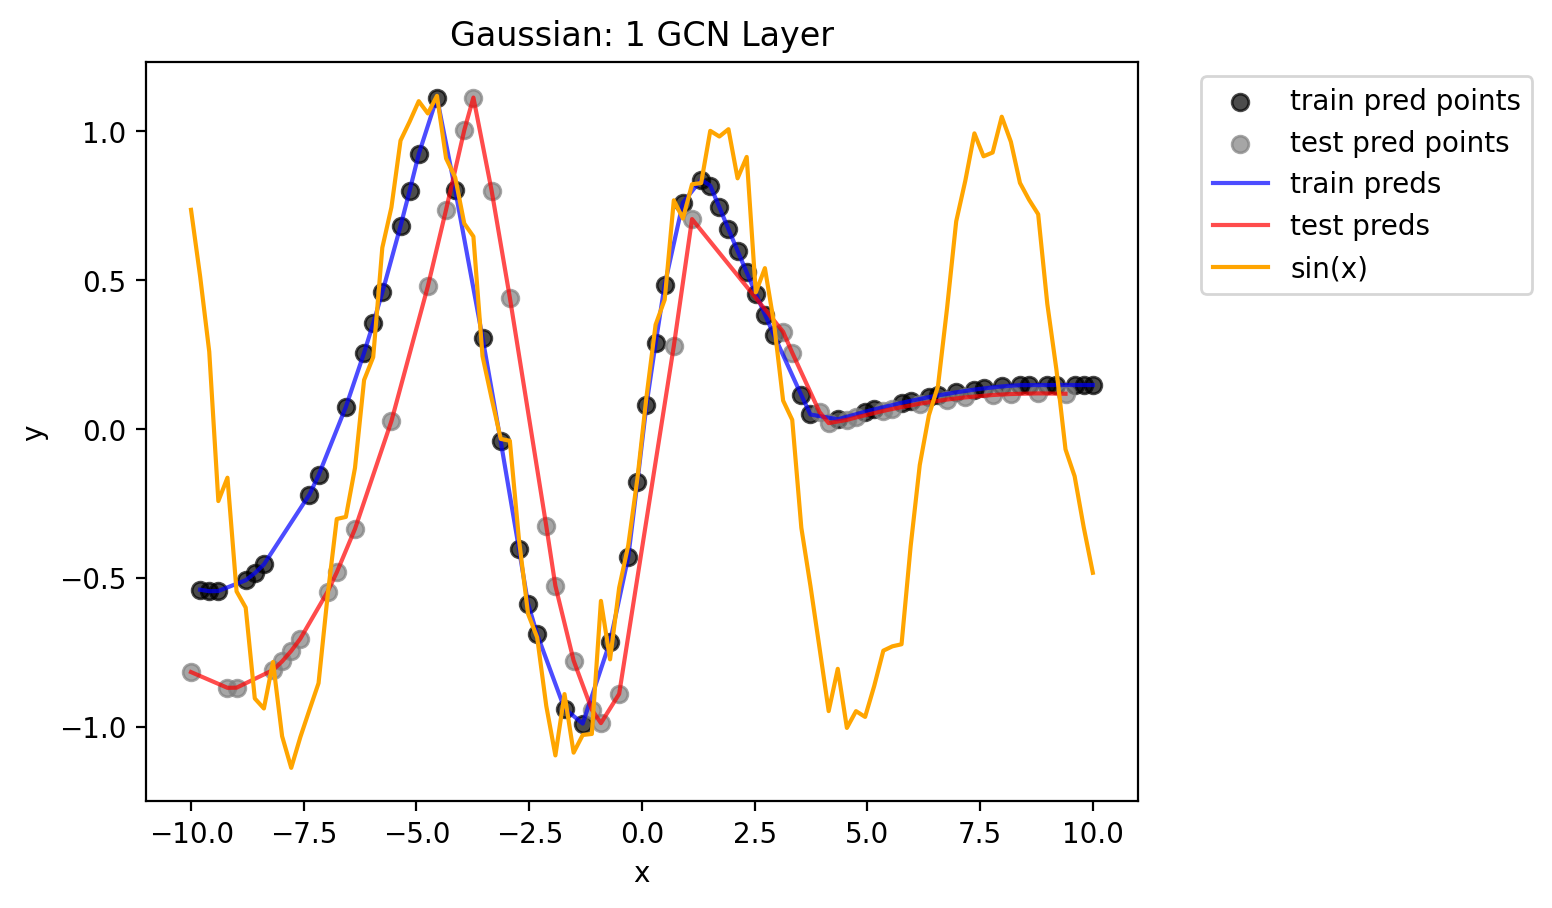

In [10]:
model = RegressionModel_1(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))
    loss = criterion(out.squeeze().cpu(), train_data.y.squeeze().cpu())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            train_out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))  
            test_out = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device))
            train_rmse = torch.sqrt(torch.mean((train_out.squeeze().cpu() - train_data.y.squeeze().cpu())**2))
            test_rmse = torch.sqrt(torch.mean((test_out.squeeze().cpu() - test_data.y.squeeze().cpu())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
  

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

train_pred = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device)).cpu().detach().numpy()
test_pred = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device)).cpu().detach().numpy()

train_pt, train_pred = sort_points(train_data.x, train_pred)
test_pt, test_pred = sort_points(test_data.x, test_pred)

plt.scatter(train_pt, train_pred, c='black', label = 'train pred points', alpha=0.7)
plt.scatter(test_pt, test_pred, c='grey', label = 'test pred points', alpha=0.7)

plt.plot(train_pt, train_pred, c='blue', label = 'train preds', alpha=0.7)
plt.plot(test_pt, test_pred, c='red', label = 'test preds', alpha=0.7)

plt.plot(torch.linspace(-10, 10, n_points), y, label = 'sin(x)', color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian: 1 GCN Layer')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# With Two Layers

100%|██████████| 5000/5000 [00:23<00:00, 215.65it/s]


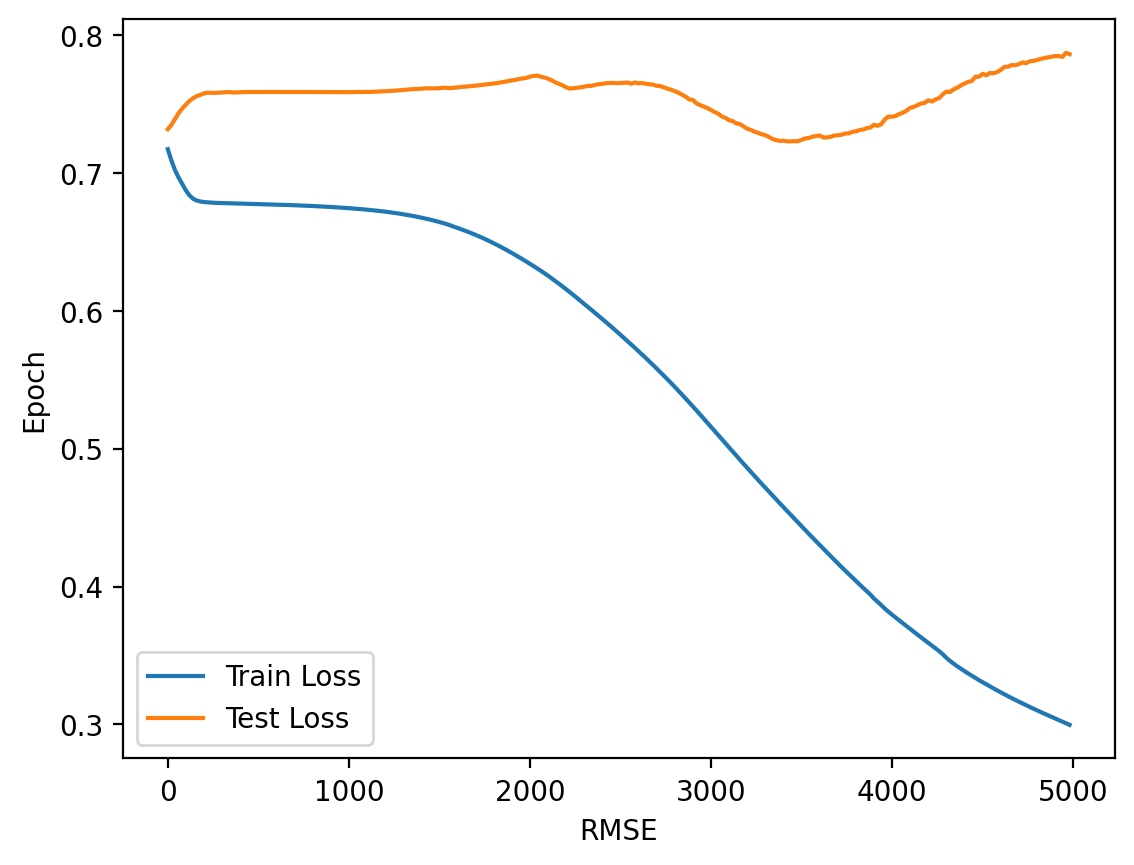

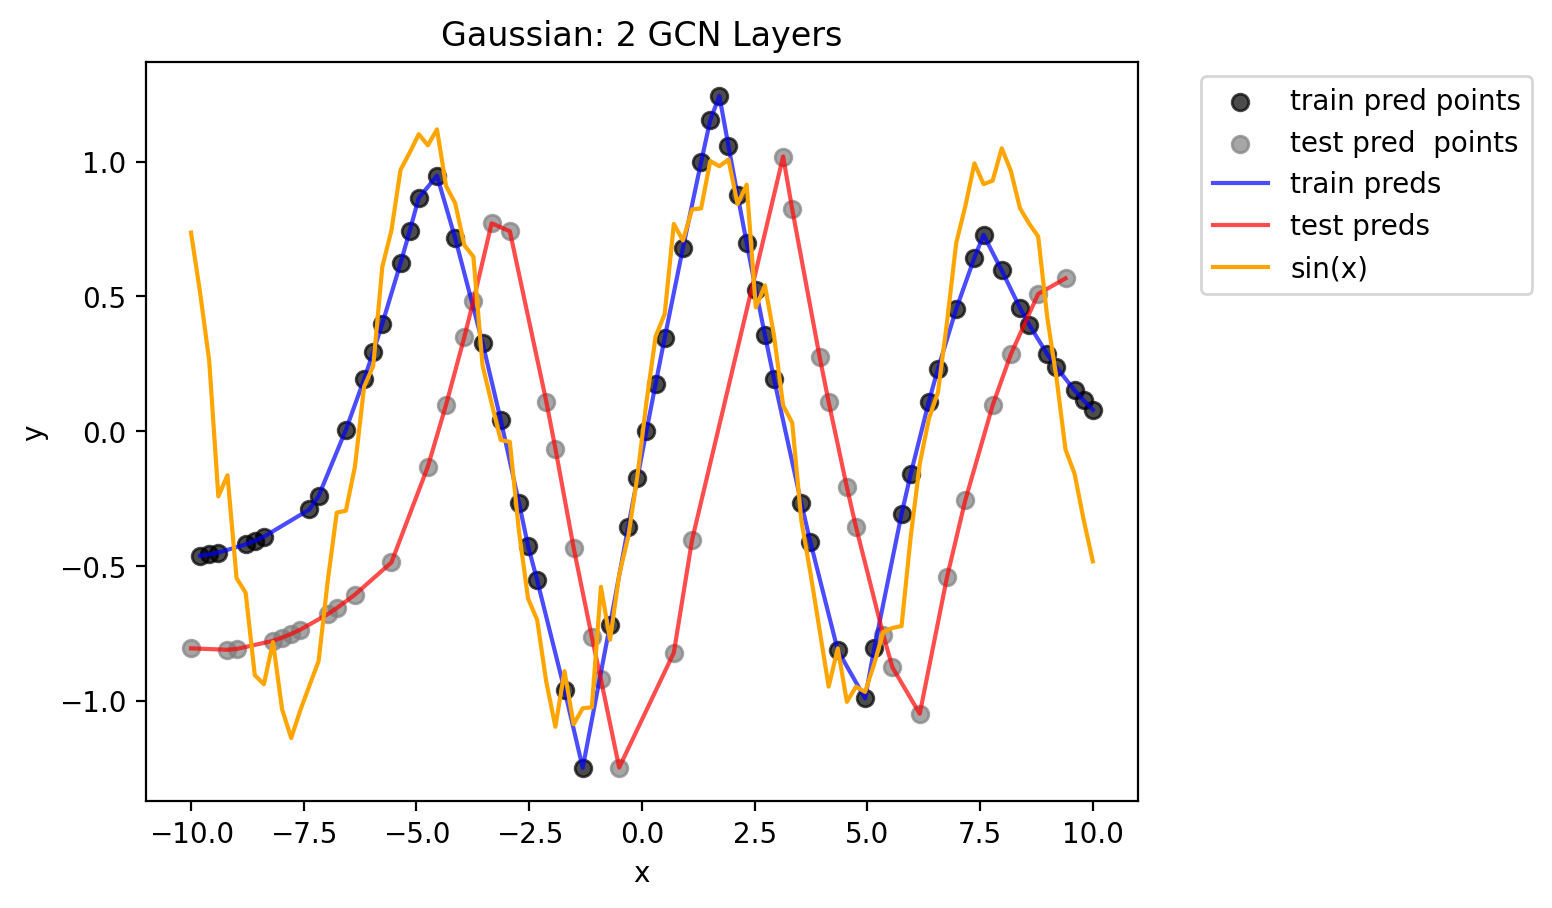

In [11]:
model = RegressionModel_2(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))
    loss = criterion(out.squeeze().cpu(), train_data.y.squeeze().cpu())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            train_out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))  
            test_out = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device))
            train_rmse = torch.sqrt(torch.mean((train_out.squeeze().cpu() - train_data.y.squeeze().cpu())**2))
            test_rmse = torch.sqrt(torch.mean((test_out.squeeze().cpu() - test_data.y.squeeze().cpu())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
  

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

train_pred = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device)).cpu().detach().numpy()
test_pred = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device)).cpu().detach().numpy()

train_pt, train_pred = sort_points(train_data.x, train_pred)
test_pt, test_pred = sort_points(test_data.x, test_pred)

plt.scatter(train_pt, train_pred, c='black', label = 'train pred points', alpha=0.7)
plt.scatter(test_pt, test_pred, c='grey', label = 'test pred  points', alpha=0.7)

plt.plot(train_pt, train_pred, c='blue', label = 'train preds', alpha=0.7)
plt.plot(test_pt, test_pred, c='red', label = 'test preds', alpha=0.7)

plt.plot(torch.linspace(-10, 10, n_points), y, label = 'sin(x)', color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian: 2 GCN Layers')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# With Three Layers

100%|██████████| 5000/5000 [00:30<00:00, 165.60it/s]


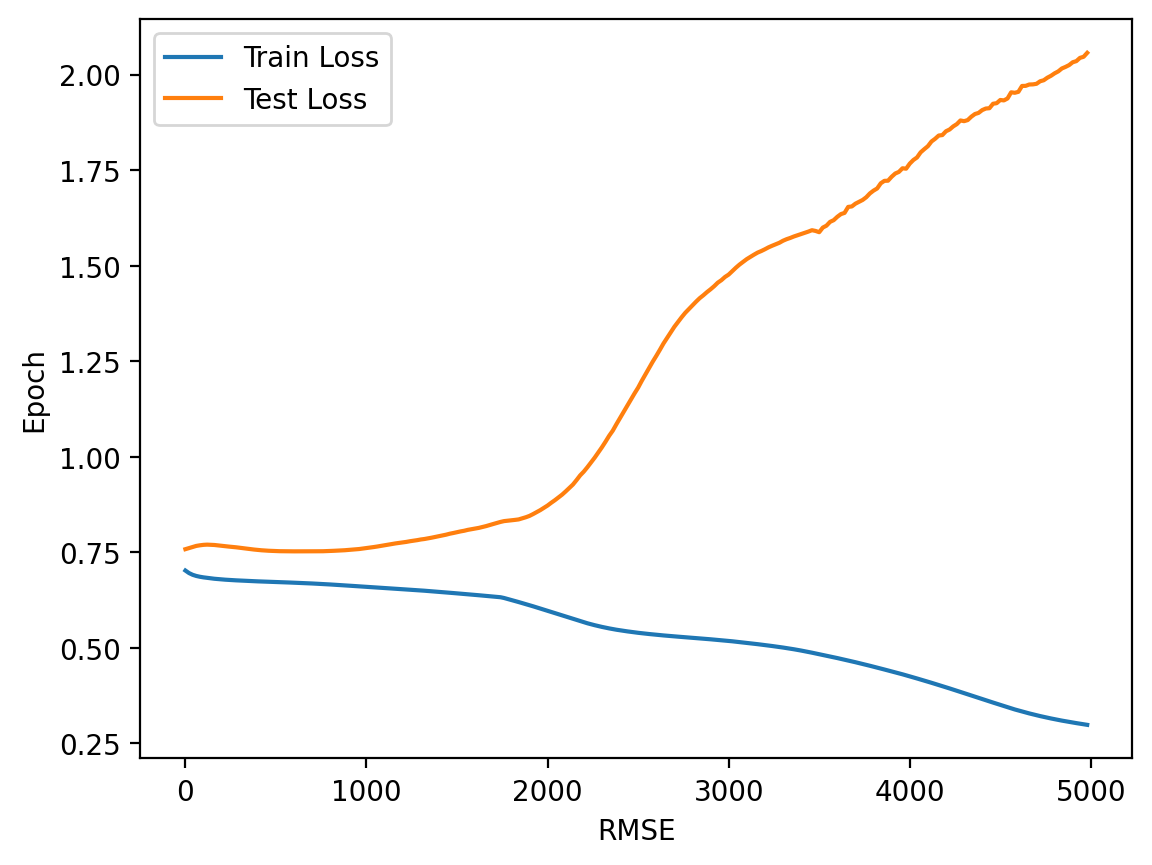

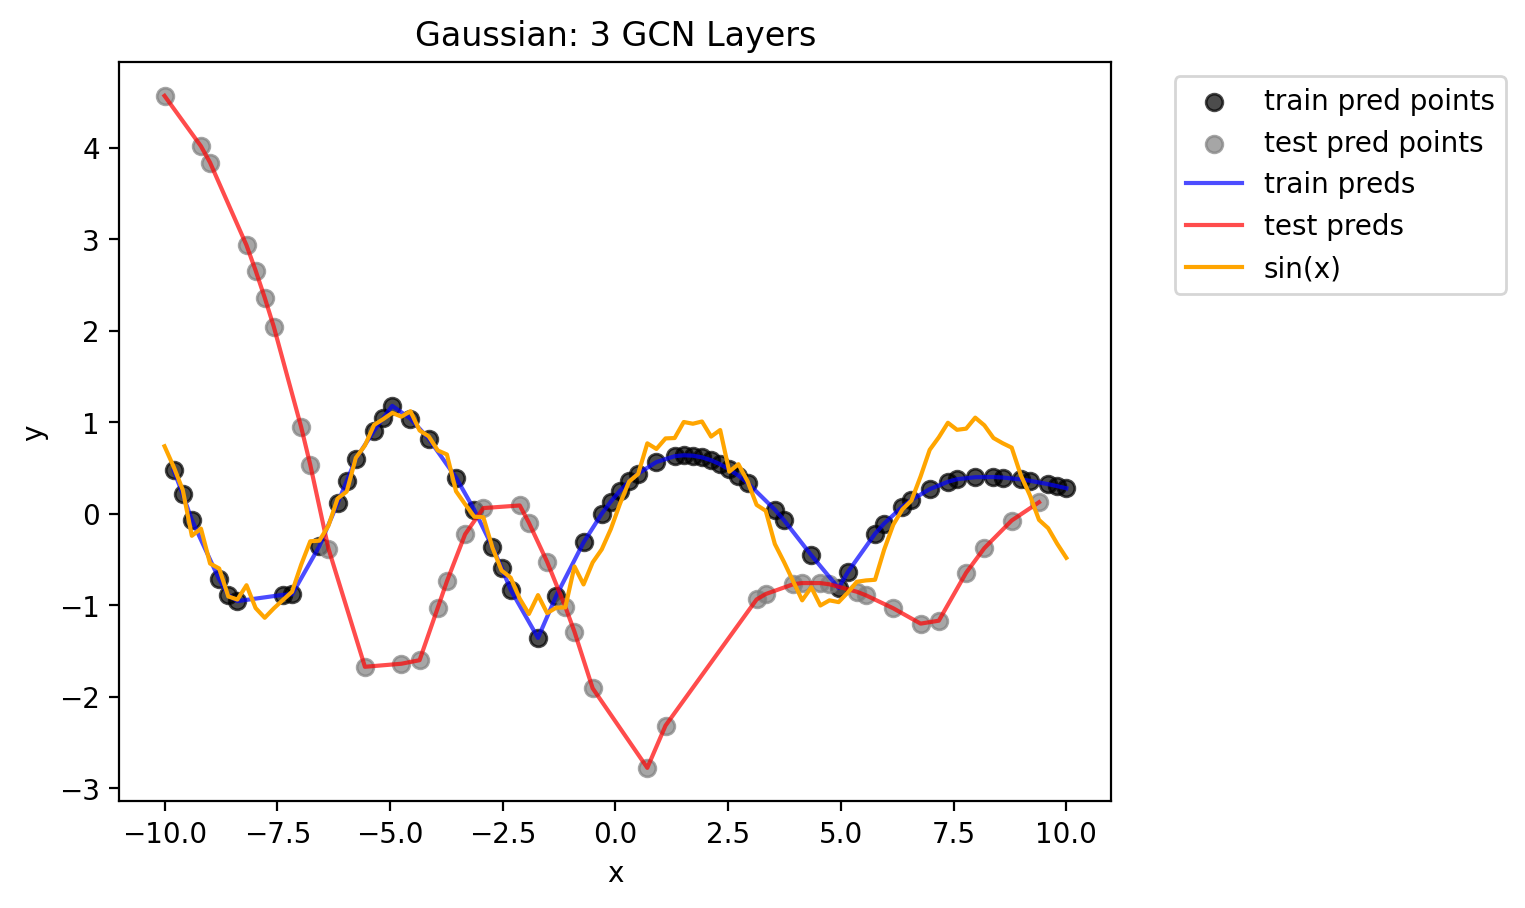

In [12]:
model = RegressionModel_3(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))
    loss = criterion(out.squeeze().cpu(), train_data.y.squeeze().cpu())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            train_out = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device))  
            test_out = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device))
            train_rmse = torch.sqrt(torch.mean((train_out.squeeze().cpu() - train_data.y.squeeze().cpu())**2))
            test_rmse = torch.sqrt(torch.mean((test_out.squeeze().cpu() - test_data.y.squeeze().cpu())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
  

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

train_pred = model(train_data.x.unsqueeze(1).to(device), train_data.edge_index.to(device), train_data.edge_weights.to(device)).cpu().detach().numpy()
test_pred = model(test_data.x.unsqueeze(1).to(device), test_data.edge_index.to(device), test_data.edge_weights.to(device)).cpu().detach().numpy()

train_pt, train_pred = sort_points(train_data.x, train_pred)
test_pt, test_pred = sort_points(test_data.x, test_pred)

plt.scatter(train_pt, train_pred, c='black', label = 'train pred points', alpha=0.7)
plt.scatter(test_pt, test_pred, c='grey', label = 'test pred points', alpha=0.7)

plt.plot(train_pt, train_pred, c='blue', label = 'train preds', alpha=0.7)
plt.plot(test_pt, test_pred, c='red', label = 'test preds', alpha=0.7)

plt.plot(torch.linspace(-10, 10, n_points), y, label = 'sin(x)', color = 'orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian: 3 GCN Layers')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()